In this notebook i'll be implementing a inversion process + uncertainty quantification using the emcee sampler.

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


import emcee

import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import numdifftools as nd

from scipy.integrate import odeint

import matplotlib.pyplot as plt

# Creating synthetic dataset

Let's start by recreating our synthetic data.

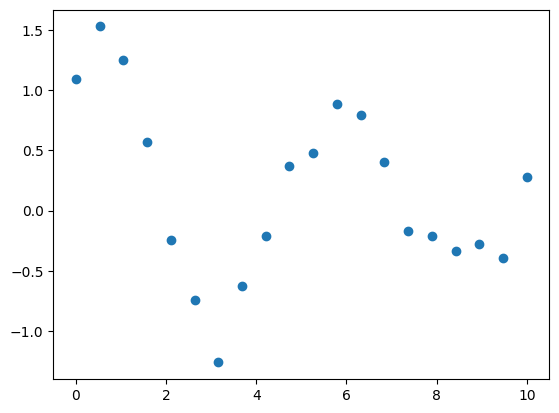

In [2]:
key = jax.random.key(42)
SIGMA = 0.2

initial_cond = (1.1, 1.2)
x0, v0 = initial_cond

def damped_oscillator_scipy(X, t, beta, k):
    x, v = X
    dxdt = v
    dvdt = -beta * v - k * x
    return [dxdt, dvdt]

ts = np.linspace(0, 10, 20)

beta = 0.3
k = 1.5

solution = odeint(damped_oscillator_scipy, initial_cond, ts, args=(beta, k))


ts = jnp.array(ts)
ys = jnp.array(solution[:, 0])
ys = ys + SIGMA*jax.random.normal(key, shape=ys.shape)

plt.scatter(ts, ys)

# Loading DeepONet

Now load our deeponet from its file.

In [3]:
from typing import Callable

class DeepOnet(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
        self, 
        in_branch: int,
        in_trunk: int,
        width: int,
        depth: int,
        interact: int,
        activation: Callable,
        *,
        key
    ):
        """
        Simplified deeponet using twin hidden architectures
        """

        b_key, t_key = jax.random.split(key)

        self.branch_net = eqx.nn.MLP(
            in_branch,
            interact,
            width,
            depth,
            activation,
            key=b_key
        )

        self.trunk_net = eqx.nn.MLP(
            in_trunk,
            interact,
            width,
            depth,
            activation,
            final_activation=activation,
            key=b_key
        )

        self.bias = jnp.zeros((1,))

    
    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """

        branch_out = self.branch_net(x_branch)
        trunk_out = self.trunk_net(x_trunk)

        inner_product = jnp.sum(branch_out*trunk_out, keepdims=True)

        return (inner_product + self.bias)[0]


deeponet = DeepOnet(
    4,
    1,
    64,
    6,
    32,
    activation=jax.nn.relu,
    key=jax.random.key(463)
)
        
deeponet = eqx.tree_deserialise_leaves("best_model.eqx", deeponet)

# Defining log posterior

Let's now define a log prior and log likelihood to then define the log posterior. Our parameters are $(k, \beta, x_0, v_0)$ we know that they can't live outside our parameter space we can model this as a uniform prior over the space the DeepONet is trained on to avoid it getting out of it and letting it free over the trained space.

In [4]:

@jax.jit
def log_likelihood_deeponet(theta):
    out = jax.vmap(deeponet, in_axes=(None, 0))(theta, ts.reshape(-1, 1))
    return -0.5 * jnp.sum((ys - out) ** 2 / SIGMA**2)     


def log_likelihood_numerical(theta):
    k, beta, *initial_cond = theta
    out = odeint(damped_oscillator_scipy, initial_cond, ts, args=(beta, k))[:, 0]
    return -0.5 * jnp.sum((ys - out) ** 2 / SIGMA**2)    


def log_prior(theta):
    if all((0  <= theta) & (theta <= 5)):
        return 0.0
    return -np.inf


def log_probability_deeponet(theta):
    lp = log_prior(theta)
    if not jnp.isfinite(lp):
        return -jnp.inf
    return lp + log_likelihood_deeponet(theta)

def log_probability_numerical(theta):
    lp = log_prior(theta)
    if not jnp.isfinite(lp):
        return -jnp.inf
    return lp + log_likelihood_numerical(theta)
    

# Checking computational cost

In [5]:
theta = jnp.array(np.random.uniform(0, 5, size=(4,)))

In [6]:
%%timeit
log_probability_deeponet(theta)

784 μs ± 105 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
grad_lik = jax.grad(log_probability_deeponet)

In [34]:
%%timeit
grad_net =  grad_lik(theta)

3.67 ms ± 73.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
grad_net =  grad_lik(theta)

In [38]:
%%timeit
grad_num = nd.Gradient(log_probability_numerical)(np.array(theta))

154 ms ± 289 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
grad_num = nd.Gradient(log_probability_numerical)(np.array(theta))

In [45]:
abs(grad_num - grad_net)/abs(grad_num)

Array([0.06438166, 0.01933139, 0.04170793, 0.09469375], dtype=float32)

In [47]:
%%timeit
nd.Gradient(log_probability_deeponet)(np.array(theta))

54.9 ms ± 211 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
grad_numnet = nd.Gradient(log_probability_deeponet)(np.array(theta))

In [52]:
grad_net - grad_numnet

Array([-0.00352097, -0.03161621, -0.01478577,  0.0100565 ], dtype=float32)

In [83]:
theta = np.random.uniform(0, 5, size=(4,))

In [21]:
%%timeit
log_probability_numerical(theta)

116 ms ± 411 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Running EMCEE

In [55]:
import emcee

pos = np.random.uniform(0, 5, size=(10, 4))
nwalkers, ndim = pos.shape

sampler_net = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_deeponet,
)

sampler_net.run_mcmc(pos, 10_000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 217.42it/s]


In [56]:
pos = np.random.uniform(0, 5, size=(10, 4))
nwalkers, ndim = pos.shape

sampler_num = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_numerical,
)

sampler_num.run_mcmc(pos, 10_000, progress=True);

100%|███████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:08<00:00, 77.80it/s]


In [57]:
flat_samples = sampler_num.get_chain(discard=100, flat=True)
print(flat_samples.shape)

(99000, 4)


In [85]:
fitted  = flat_samples.mean(axis=0).tolist()
ref_vals = [k, beta, x0, v0]
labels = ["   k", "beta", "  x0", "  v0"]

print("Reference Vals vs Fitted Values\n")

for fit, ref, par in zip(fitted, ref_vals, labels):
    print(f"{par} - ref: {ref:5.2f} - fit: {fit:5.2f}")

Reference Vals vs Fitted Values

   k - ref:  1.50 - fit:  1.48
beta - ref:  0.30 - fit:  0.29
  x0 - ref:  1.10 - fit:  1.15
  v0 - ref:  1.20 - fit:  1.25


In [54]:
sampler_net.acceptance

NameError: name 'sampler_net' is not defined

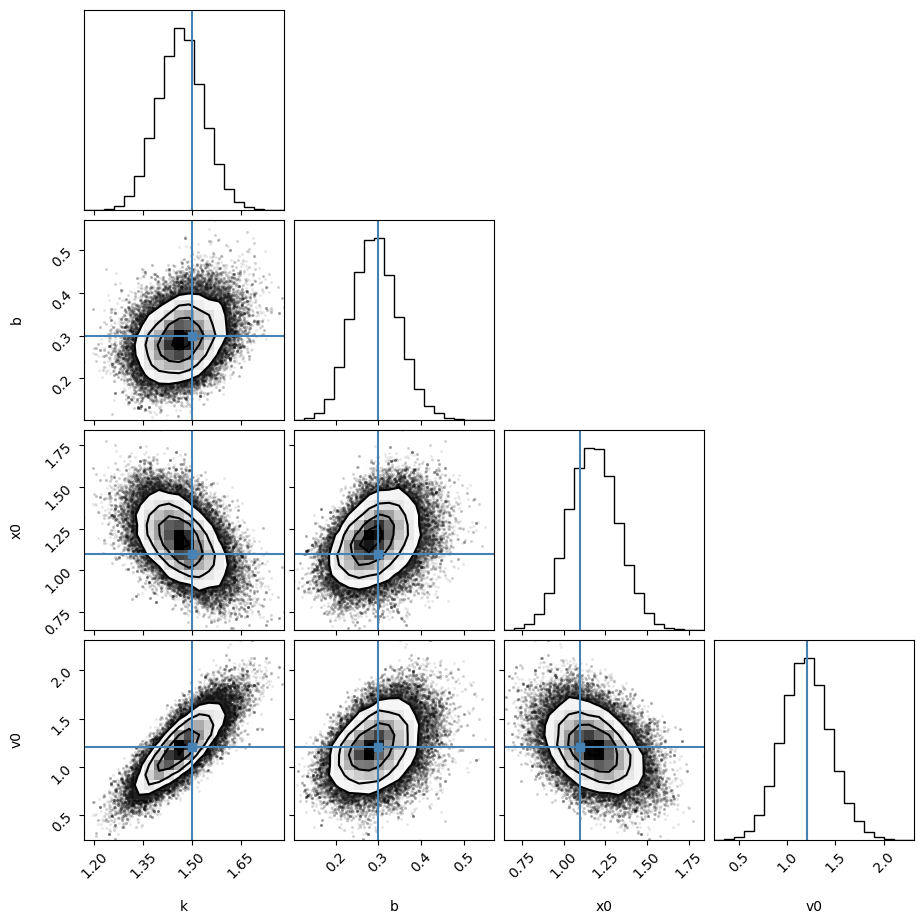

In [58]:
import corner
labels = ["k", "b", "x0", "v0"]

fig = corner.corner(
    flat_samples, labels=labels, truths=[k, beta, x0, v0]
);

It worked just fine !!! Let's now go to the big test, analyse this chain using ArViz.


# ArViz analysis

Let's build the $\hat{R}$ timeline.

In [32]:
import arviz

In [33]:
idata_numeric = arviz.from_emcee(sampler_num)
idata_net =  arviz.from_emcee(sampler_net)

idata = idata_net  ## Set with one to plot

NameError: name 'sampler_num' is not defined

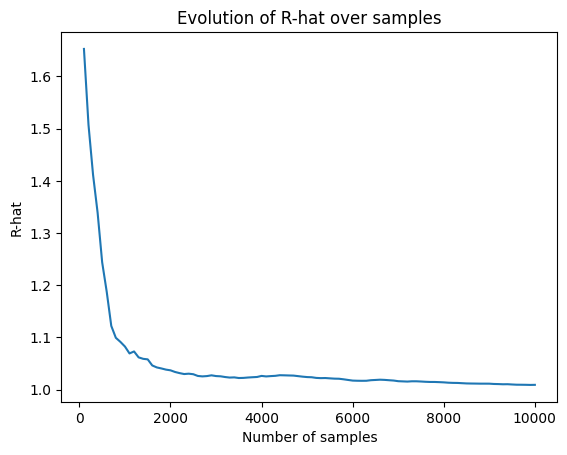

In [66]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# Suppose you have your inference data (posterior samples) in 'idata'
# and want to calculate R-hat in progressive chunks

# Number of samples per chunk
chunk_size = 100
num_samples = idata.posterior.sizes["draw"]
rhat_values = []

for i in range(chunk_size, num_samples + 1, chunk_size):
    # Slice the samples up to i-th sample
    partial_idata = idata.sel(draw=slice(0, i))
    # Compute R-hat for this subset
    rhat = az.rhat(partial_idata)
    # Average R-hat over parameters (or select specific parameter)
    rhat_mean = rhat.to_array().mean().item()
    rhat_values.append(rhat_mean)

# Plot evolution
plt.plot(range(chunk_size, num_samples + 1, chunk_size), rhat_values)
plt.xlabel("Number of samples")
plt.ylabel("R-hat")
plt.title("Evolution of R-hat over samples")
plt.show()


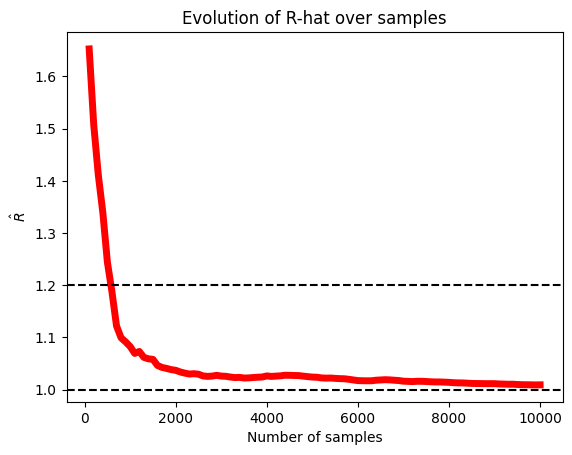

In [71]:
# Plot evolution
plt.plot(range(chunk_size, num_samples + 1, chunk_size), rhat_values, c="r", lw=5)
plt.axhline(y=1.2, ls="--", c="k")
plt.axhline(y=1.0, ls="--", c="k")
plt.xlabel("Number of samples")
plt.ylabel(r"$\hat{R}$")
# plt.yscale("log")
plt.title("Evolution of R-hat over samples")
plt.show()


In [53]:
sampler.acceptance_fraction

NameError: name 'sampler' is not defined

In [28]:
tau = sampler.get_autocorr_time()
print(tau)

[51.78392665 57.07450809 56.39697325 55.35663442]


# Saving results

In [89]:
idata_net.to_netcdf("../../outputs/inference_data_emcee+deeponet.nc")
idata_numeric.to_netcdf("../../outputs/inference_data_emcee+simulator.nc")

'../../outputs/inference_data_emcee+simulator.nc'